In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [21]:
batch_size = 32
img_height = 48
img_width = 48

train_dir = 'Data_Sets/train'
test_dir = 'Data_Sets/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Emotion Categories:", class_names)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Emotion Categories: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [24]:
import os
import pandas as pd

def count_images_per_class(directory):
    class_counts = {}
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):
            class_counts[emotion] = len(os.listdir(emotion_path))
    return class_counts

train_counts = count_images_per_class('Data_Sets/train')
test_counts = count_images_per_class('Data_Sets/test')

df_counts = pd.DataFrame({
    "Emotion": list(train_counts.keys()),
    "Train Count": list(train_counts.values()),
    "Test Count": [test_counts.get(emotion, 0) for emotion in train_counts.keys()]
})
df_counts.sort_values("Train Count", ascending=False, inplace=True)
df_counts

,Emotion,Train Count,Test Count
3,happy,7215,1774
4,neutral,4965,1233
5,sad,4830,1247
2,fearful,4097,1024
0,angry,3995,958
6,surprised,3171,831
1,disgusted,436,111


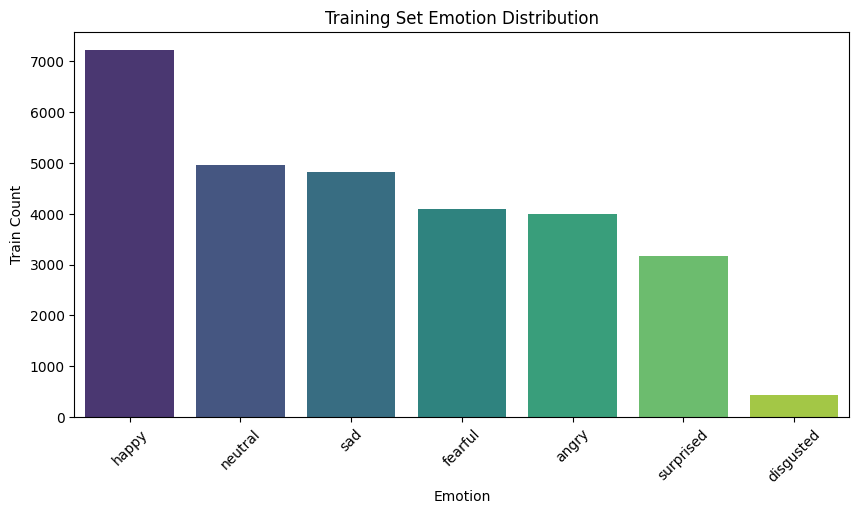

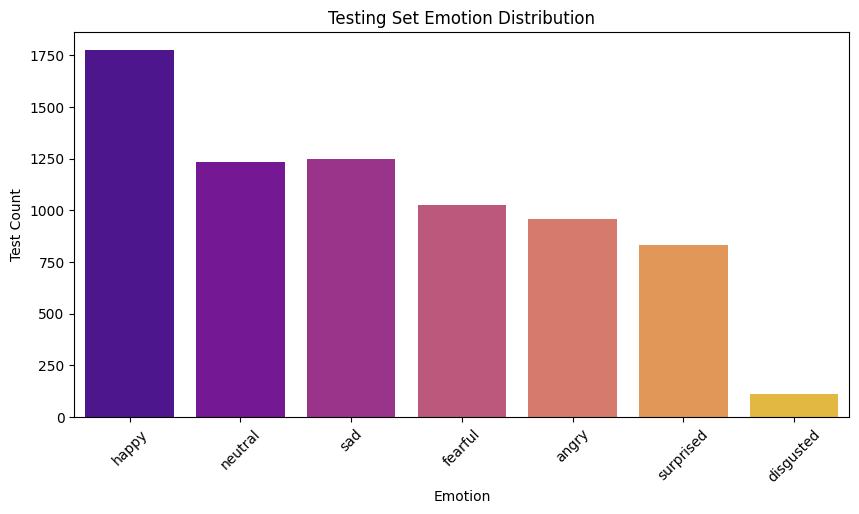

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(x="Emotion", y="Train Count", data=df_counts, palette="viridis")
plt.title("Training Set Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="Emotion", y="Test Count", data=df_counts, palette="plasma")
plt.title("Testing Set Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

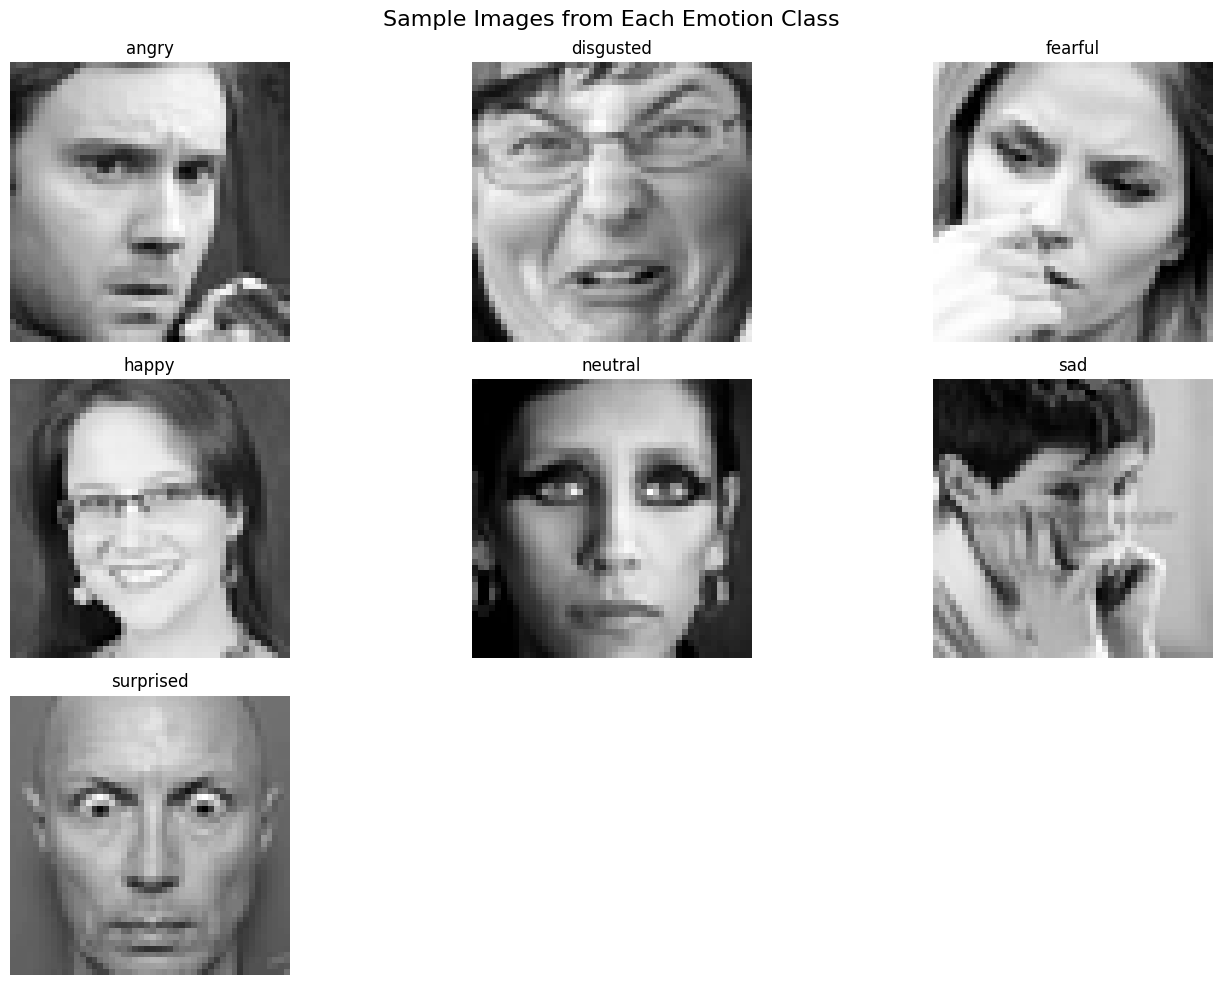

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_samples(data_dir, class_names):
    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        image_name = os.listdir(class_path)[0]  # First image
        image_path = os.path.join(class_path, image_name)
        img = mpimg.imread(image_path)

        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')

    plt.suptitle("Sample Images from Each Emotion Class", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples('Data_Sets/train', class_names)

In [27]:

from PIL import Image
from collections import Counter

def get_image_shapes(directory):
    shapes = []
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):
            for file in os.listdir(emotion_path):
                file_path = os.path.join(emotion_path, file)
                try:
                    with Image.open(file_path) as img:
                        shapes.append(img.size)
                except:
                    continue
    return Counter(shapes)

train_shapes = get_image_shapes('Data_Sets/train')
print("Most common image shapes in training set:", train_shapes.most_common(5))

Most common image shapes in training set: [((48, 48), 28709)]


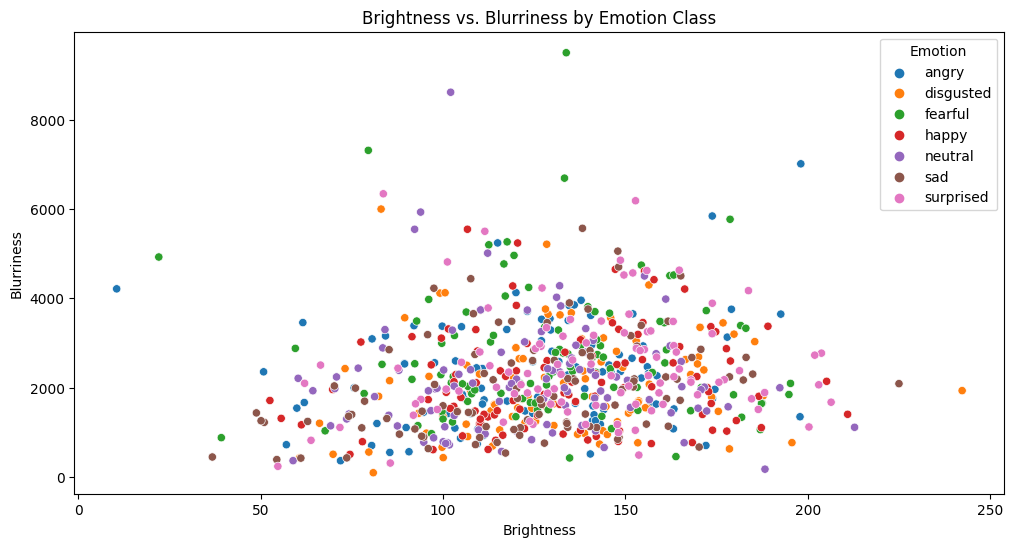

In [28]:
brightness_vs_blur = []

for emotion in os.listdir('Data_Sets/train'):
    emotion_dir = os.path.join('Data_Sets/train', emotion)
    for img_name in os.listdir(emotion_dir)[:100]:
        img_path = os.path.join(emotion_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness = np.mean(img)
            blur_score = cv2.Laplacian(img, cv2.CV_64F).var()
            brightness_vs_blur.append((emotion, brightness, blur_score))

df_bvb = pd.DataFrame(brightness_vs_blur, columns=['Emotion', 'Brightness', 'Blurriness'])

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_bvb, x='Brightness', y='Blurriness', hue='Emotion', palette='tab10')
plt.title("Brightness vs. Blurriness by Emotion Class")
plt.show()

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [30]:

import hashlib

hash_dict = {}

def hash_image(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

for emotion in os.listdir('Data_Sets/train'):
    emotion_dir = os.path.join('Data_Sets/train', emotion)
    for img_name in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_name)
        try:
            img_hash = hash_image(img_path)
            if img_hash not in hash_dict:
                hash_dict[img_hash] = [(emotion, img_name)]
            else:
                hash_dict[img_hash].append((emotion, img_name))
        except:
            continue

duplicates = {k: v for k, v in hash_dict.items() if len(v) > 1}
print(f"Found {len(duplicates)} duplicate images.")


Found 1035 duplicate images.


In [31]:
batch_size = 32
img_size = (48, 48)

train_ds = image_dataset_from_directory("Data_Sets/train",
                                        label_mode='int',
                                        image_size=img_size,
                                        batch_size=batch_size,
                                        shuffle=True)

val_ds = image_dataset_from_directory("Data_Sets/test",
                                      label_mode='int',
                                      image_size=img_size,
                                      batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [32]:
# Extract labels for computing weights
y_labels = []
for images, labels in train_ds.unbatch():
    y_labels.append(labels.numpy())

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_labels),
                                     y=np.array(y_labels))

class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights)

Class Weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [33]:
def build_emotion_cnn(input_shape=(48, 48, 3), num_classes=7):
    model = models.Sequential()

    model.add(layers.Rescaling(1./255, input_shape=input_shape))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_emotion_cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)      

In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_emotion_model.h5", save_best_only=True)
]

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'): #Use the first detected GPU

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
898/898 [==============================] - 155s 173ms/step - loss: 1.9550 - accuracy: 0.2784 - val_loss: 1.6842 - val_accuracy: 0.3746
Epoch 2/20
898/898 [==============================] - 152s 169ms/step - loss: 1.6534 - accuracy: 0.3638 - val_loss: 1.8964 - val_accuracy: 0.4172
Epoch 3/20
898/898 [==============================] - 146s 163ms/step - loss: 1.5180 - accuracy: 0.4140 - val_loss: 1.7922 - val_accuracy: 0.3009
Epoch 4/20
898/898 [==============================] - 140s 156ms/step - loss: 1.4445 - accuracy: 0.4339 - val_loss: 2.0638 - val_accuracy: 0.3817
Epoch 5/20
898/898 [==============================] - 144s 160ms/step - loss: 1.4116 - accuracy: 0.4466 - val_loss: 1.3985 - val_accuracy: 0.4721
Epoch 6/20
898/898 [==============================] - 200s 223ms/step - loss: 1.3609 - accuracy: 0.4662 - val_loss: 1.4244 - val_accuracy: 0.4696
Epoch 7/20
898/898 [==============================] - 152s 170ms/step - loss: 1.3223 - accuracy: 0.4775 - val_loss: 1.3147 -

In [36]:
#save the model architecture + weights + optimizer state
model.save('ML_model\emotion_model.h5')
print('Model saved as emotion_model.h5')


Model saved as emotion_model.h5


In [37]:
model.save('ML_mode\emotion_model_saved',save_format='tf')
print('Model saved in TensorFlow SavedModel Format')



INFO:tensorflow:Assets written to: ML_mode\emotion_model_saved\assets


INFO:tensorflow:Assets written to: ML_mode\emotion_model_saved\assets


Model saved in TensorFlow SavedModel Format


In [ ]:
#save architecture only 
model_json = model.to_json()
with open("ML_Model\emotion_model_architecture.json")
